# Project Question
## What factors affected New Zealand's economy(GDP) during Covid?

---

### Summary:
- Accessing StatNZ API and configuring its columns to return the desired datasets
- Total filled jobs dataset from StatNZ API
- Net export dataset from StatNZ API
- Total number of tourists dataset from webscraping
- GDP dataset from webscraping
- Relational Dataset and plots

### Purpose

I chose this topic as it was very timely and relevant. 

I want to know if Covid affected the GDP of New Zealand between 2019 - 2020 
and what factors contributed to that effect.
To keep it consistent, the chosen factors were affected by Covid as well.

GDP (Gross Domestic Product) - the monetary value of all completed products and services produced inside a country over a certain period.
GDP is a measure of that country's economic wealth that is used to determine its size and rate of growth.

https://www.investopedia.com/terms/g/gdp.asp

---

### Factors and the reason why we chose that

 - Total filled jobs - The reasoning here is that if there is less filled jobs then there is less hours worked therefore less productivity.
   Less productivity means less economic growth.

 - Net export - The reasoning here is that export adds value to GDP whereas import subtracts. 
   Net export is export - import which is a rough approximation that tells if export is higher than import.
   Less net export then less economic growth.

 - Total number of tourist - The reasoning here is that is that if there less tourist then less profits. Less profits mean less economic growth. 

https://www.investopedia.com/terms/g/gdp.asp

---

### Data wrangling

In [1]:
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings
library(rvest) # rvest makes scraping easier
library(polite) # polite is the "polite" version of rvest
library(xml2) # makes it easier to work with HTML and XML from R
library(httr)
library(jsonlite)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Loading necessary packages that will be helpful when wrangling the data. I have included everything to be sure.

---

### Accessing Stats NZ API

Before any of this, I have subscribed to Stats NZ API and were given an account and key.

The function below obtains the catalogue of the datasets. 

This needs 'service' which is the link of Stats NZ API open data, 'endpoint' or url of the server (or service) and 'service_api_key' which is the key given by Stats NZ API. 

In [2]:
get_odata_catalogue <-  function(service, endpoint, service_api_key) {
  
  catalogue_url <- URLencode(paste0(service, "/", endpoint))
  
  # Add the proxy authentication
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service), 
    auth = "any", 
    username = ""
  )
  
  # Look at the available tables
  opendata_catalogue <- 
    GET(
      url = catalogue_url,
      config_proxy,
      add_headers(.headers = c('Cache-Control' = 'no-cache',
                               'Ocp-Apim-Subscription-Key' = service_api_key)),
      timeout(60)
    ) %>%
    content(as = "text") %>%
    fromJSON()
  
  opendata_catalogue <- as.data.frame(opendata_catalogue$dataset) %>%
    unnest_longer(distribution)
  
  
  structure(opendata_catalogue,
            comment = "Odata Catalogue")
  
}

The code below shows that the Catalogue is using the function get_odata_catalogue.

In [3]:
Catalogue <- get_odata_catalogue(
  service="https://api.stats.govt.nz/opendata/v1",
  endpoint="data.json",
  service_api_key = " 177b5ce997aa403bbe5b0da554cc96f5 "
)

Catalogue %>% typeof()
Catalogue %>% glimpse()

[1] "list"

Rows: 4
Columns: 16
$ title              <chr> "Employment Indicators", "Overseas Cargo", "Covid19…
$ description        <chr> "This employment indicator series is intended to pr…
$ identifier         <chr> "https://api.stats.govt.nz/odata/v1/EmploymentIndic…
$ license            <chr> "https://creativecommons.org/licenses/by/4.0/", "ht…
$ keyword            <list> <"Employment", "ResourceID MEI1.1: Filled jobs and…
$ issued             <chr> "2020-08-11T19:45:06Z", "2020-08-06T23:31:28Z", "20…
$ modified           <chr> "2020-12-10T22:39:15Z", "2020-12-10T22:51:17Z", "20…
$ publisher          <df[,2]> <data.frame[4 x 2]>
$ contactPoint       <df[,3]> <data.frame[4 x 3]>
$ landingPage        <chr> "https://www.stats.govt.nz", "https://www.stats.…
$ language           <list> "en", "en", "en", "en"
$ accrualPeriodicity <chr> "Monthly", "Monthly", "Weekly", "Monthly"
$ theme              <chr> "Employment", "Commerce, trade and industry", ""…
$ temporal           <chr> "1999-04-30/", "198

Catalogue is of type list and passing glimpse() gives its columns. 
I will be focusing on the title and description for the desired dataset.

In [4]:
Catalogue$title %>% as.factor() %>% levels() 
Catalogue$description %>% as.factor() %>% levels()

[1] "Covid19 Indicators"      "Employment Indicators"  
[3] "International Migration" "Overseas Cargo"

[1] "International migration measures long-term arrivals and departures to and from New Zealand. This is an outcomes-based measure of migration estimated from the actual travel histories of people travelling in and out of New Zealand.\n  Before November 2018, Stats NZ classified travellers based on the intentions they stated on their passenger cards when they crossed the border. Calculating the actual travel duration (outcomes-based measure) is a more accurate way of measuring migration than relying on passenger card intentions. The outcomes-based measure is available back to January 2000.\n  With the removal of the departure cards in November 2018, Stats NZ made methodological changes to producing the official measures of migration, tourism, and the estimates of population.\n  For more informaiton refer to https://datainfoplus.stats.govt.nz/Item/nz.govt.stats/e2190954-9bd0-4ab9-81bd-4a5407de3f19"
[2] "Overseas cargo records all goods, value and gross weight, loaded or unloaded at sea or air ports."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
[3] "Stats NZ's COVID-19 data portal indicators gather key high-frequency indicators to help track the impact of COVID-19 on the economy.\n  \t\tExternally sourced data has not been verified by Stats NZ. Decision makers using the indicators should refer to the original indicator source to understand how the data was collected and issues such as sample error."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
[4] "This employment indicator series is intended to provide an early indication of changes in the labour market.\nThese indicators use a combination of data from two different Inland Revenue sources: the Employer Monthly Schedule (EMS) and payday filing."

This code returns four different titles and description for each.
I will use 'Employment Indicators' as the endpoint.

I included the description because I will use that later when writing the report.

In [5]:
get_odata <-  function(service, endpoint, entity, query_option, service_api_key) {
  
  config_proxy <- use_proxy(
    url = curl::ie_get_proxy_for_url(service),
    auth = "any",
    username = ""
  )
  
  odata_url <- URLencode(paste0(service, "/", endpoint, "/", entity, "?", query_option))
  top_query <- grepl("$top",query_option,fixed=TRUE)
  
  # continue getting results while there are additional pages
  
  while (!is.null(odata_url)) {
    
    result <- GET(odata_url,
                  config_proxy,
                  add_headers(.headers = c("Content-Type" = "application/json;charset=UTF-8",
                                           "Ocp-Apim-Subscription-Key" = service_api_key)),
                  timeout(60)
    )
    
    
    # catch errors
    
    if (http_type(result) != "application/json") {
      stop("API did not return json", call. = FALSE)
    }
    
    
    if (http_error(result)) {
      stop(
        sprintf(
          "The request failed - %s \n%s \n%s ",
          http_status(result)$message,
          fromJSON(content(result, "text"))$value,
          odata_url
        ),
        call. = FALSE
      )
    }
    
    
    # parse and concatenate result while retaining UTF-8 encoded characters
    
    parsed <- jsonlite::fromJSON(content(result, "text", encoding = "UTF-8"), flatten = TRUE)
    response  <- rbind(parsed$value, if(exists("response")) response)
    odata_url <- parsed$'@odata.nextLink'
    
    
    cat("\r", nrow(response), "obs retrieved")
    
    # break when top(n) obs are specified
    
    if (top_query) {
      break
    }
    
  }
  
  structure(response,
            comment = "Odata response")
  
}

This function is similar to the previous get_odata_catalogue, but it now gets the dataset specifically (more on this later). 

The new function needs two additional arguments: 'query_option' for the Resource ID/Title of the dataset and 'entity' which is the catalogue title. 

In [6]:
Data <-  Filter(function(x)!all(is.na(x)),
                      get_odata(
                        service = "https://api.stats.govt.nz/opendata/v1",
                        endpoint = "EmploymentIndicators",
                        entity = "Resources",
                        query_option = "",
                        service_api_key = " 177b5ce997aa403bbe5b0da554cc96f5 "))

Data %>% glimpse()

 6 obs retrievedRows: 6
Columns: 13
$ ResourceID  <chr> "MEI1.1", "MEI2.1", "MEI3.1", "MEI4.1", "MEI5.1", "MEI6.1"
$ Subject     <chr> "Employment Indicators", "Employment Indicators", "Employm…
$ Title       <chr> "Filled jobs and total gross earnings by high level indust…
$ Description <chr> "Provides an indication of filled jobs and total earnings …
$ Notes       <chr> "This employment indicator series is intended to provide a…
$ Caveats     <chr> "Coverage of filled jobs and gross earnings by the new ind…
$ Source      <chr> "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ", "Stats NZ"…
$ SourceURL   <chr> "www.stats.govt.nz/methods/about-new-employment-indicator-…
$ Modified    <chr> "2021-09-27T21:45:00Z", "2021-09-27T21:45:00Z", "2021-09-2…
$ Frequency   <chr> "Monthly", "Monthly", "Monthly", "Monthly", "Monthly", "Mo…
$ Var1        <chr> "MEI Published Industries", "Industry", "Sex", "Treatment"…
$ Var2        <chr> "Treatment", "Treatment", "Age", NA, "Treatment", "Treatme…
$ Var

Data nests the function get_odata. 

The argument 'entity' can take "Resources" and "Observations " as Stats NZ API works like a relation database. 
Resources stores the data about datasets and "Observations" are the actual data about datasets.
In this case the 'entity' is "Resources" to return the column ResourceID via glimpse().

'query_option' is left blank because I am not specifying the dataset at this point.

In [7]:
Data %>% group_by(ResourceID, Title) %>% summarise() %>% print(n=nrow(.))

`summarise()` has grouped output by 'ResourceID'. You can override using the `.groups` argument.



# A tibble: 6 × 2
# Groups:   ResourceID [6]
  ResourceID Title                                                      
  <chr>      <chr>                                                      
1 MEI1.1     Filled jobs and total gross earnings by high level industry
2 MEI2.1     Filled jobs by industry                                    
3 MEI3.1     Filled jobs by age group and sex                           
4 MEI4.1     Filled jobs by regional council                            
5 MEI5.1     Filled jobs by regional council and sex                    
6 MEI6.1     Filled jobs by regional council and age group              


Data is grouped by ResourceID and Title then its rows are printed via print(n=nrow(.)). 

The dataset 'Filled jobs by regional council' with an ID 'MEI4.1' is what I'll be working with.
I will pass in 'MEI4.1' as an argument to 'query_option' to specify that this is the dataset to be returned.

So far, there are five arguments sorted:

'service' = "https://api.stats.govt.nz/opendata/v1",

'endpoint' = "EmploymentIndicators",

'entity' = "Resources",

'query_option' = "$filter=(ResourceID eq 'MEI4.1')",

'service_api_key' = " 177b5ce997aa403bbe5b0da554cc96f5 "

---

### Getting the "Total Number of Filled Jobs" dataset

The code below returns the dataset of 'Filled jobs by regional council'.

In [8]:
filled_jobs <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "EmploymentIndicators",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'MEI4.1')",
                           service_api_key = " 177b5ce997aa403bbe5b0da554cc96f5 "))

filled_jobs

 448 obs retrieved

,id,ResourceID,GeoUnit,Geo,Period,Duration,Label1,Value,Unit,Measure,Multiplier,Status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>
1,e1da8d10-106e-43eb-8fc4-cfcd791225cb,MEI4.1,REGC2020,Auckland Region,2019-05-31,P1M,Actual,721535,Number,Filled jobs,0,F
2,c6c50372-e2b6-4ac0-8c58-24635e03997c,MEI4.1,REGC2020,Bay of Plenty Region,2019-05-31,P1M,Actual,134191,Number,Filled jobs,0,F
3,438e6d63-e131-436d-bd4e-d08263702126,MEI4.1,REGC2020,Canterbury Region,2019-05-31,P1M,Actual,291133,Number,Filled jobs,0,F
4,452dfd87-a4ca-4519-8590-79dc987356c3,MEI4.1,REGC2020,Gisborne Region,2019-05-31,P1M,Actual,21233,Number,Filled jobs,0,F
5,c2526998-e651-4c40-a148-42300e8fbf07,MEI4.1,REGC2020,Hawke's Bay Region,2019-05-31,P1M,Actual,75347,Number,Filled jobs,0,F
6,039fa9df-62db-43d8-9f1e-16459907c381,MEI4.1,REGC2020,Manawatu-Whanganui Region,2019-05-31,P1M,Actual,104280,Number,Filled jobs,0,F
7,af0c4cfc-4405-4bb8-9552-b0c1271850f7,MEI4.1,REGC2020,Northland Region,2019-05-31,P1M,Actual,67074,Number,Filled jobs,0,F
8,3917a3ce-1280-43ff-9346-27ee5857b661,MEI4.1,REGC2020,Otago Region,2019-05-31,P1M,Actual,107319,Number,Filled jobs,0,F
9,cce2599c-6063-489a-8dcc-5acf02ca95d6,MEI4.1,REGC2020,Southland Region,2019-05-31,P1M,Actual,47003,Number,Filled jobs,0,F


In [9]:
filled_jobs %<>% filter(!is.na(Value)) %>% group_by(Period) %>% summarize(total_filled_jobs = sum(Value))
filled_jobs

Period,total_filled_jobs
<chr>,<int>
2019-05-31,2139459
2019-06-30,2133359
2019-07-31,2138847
2019-08-31,2141256
2019-09-30,2154615
2019-10-31,2166208
2019-11-30,2207346
2019-12-31,2229757
2020-01-31,2173656


The target here is to get the 'Value' for each 'Period'. 

Hence, the code above gets rid of the null values by filter(), then it is group into distinct 'Period' and then get the sum of all Values with that distinct 'Period'.

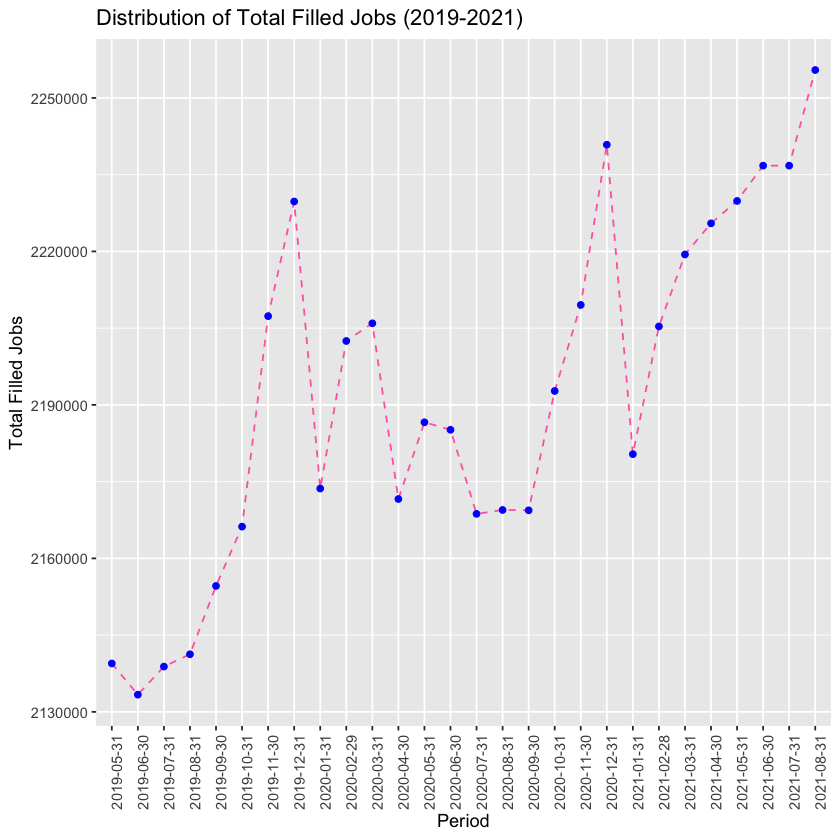

In [10]:
filled_plot <- filled_jobs %>% ggplot(aes(x=Period, y=total_filled_jobs, group=1)) + 
geom_line(linetype = "dashed", color="hotpink") + 
geom_point(color="blue") + 
theme(axis.text.x = element_text(angle = 90)) +
labs(title = "Distribution of Total Filled Jobs (2019-2021)", x = "Period", y = "Total Filled Jobs")
filled_plot

The plot shows that there are four significant decreases in the number of filled jobs from 2019 to 2021. 

The first decrease is between December 2019 to January 2020 by (2229757-2173656) 56,101 jobs and this is when Covid was made official and was all over the news.

The second decrease is when the first lockdown happened between March 2020 to April 2020 (2205951-2171602) by 34,349 jobs. Non-essential businesses were closed at that time so they were not filled.

The third decrease happened between June 2020 to July 2020 (2185138-2168699) by 16,436 jobs and this is due to businesses (especially small businesses) closing down as they cannot handle to operate due to losses created by the lockdown.

The fourth decrease happened between December 2020 to January 2021 (2240855-2180367) by 60,488 jobs . This is due to the Covid-19 support schemes not being enough, and the Delta variant was discovered.

https://www.rnz.co.nz/news/national/437359/timeline-the-year-of-covid-19-in-new-zealand

Overall, this implies that total filled jobs were affected during Covid.

---

### Getting the 'Net Export' dataset

The following codes for getting the 'net export' dataset are similar to the codes for getting the 'total number of filled jobs' dataset. 

Therefore, I will only state what is different and highlight the important bits.

In [11]:
Data1 <-  Filter(function(x)!all(is.na(x)),
                      get_odata(
                        service = "https://api.stats.govt.nz/opendata/v1",
                        endpoint = "OverseasCargo",
                        entity = "Resources",
                        query_option = "",
                        service_api_key = " 177b5ce997aa403bbe5b0da554cc96f5 ")) 

Data1 %>% glimpse()

 1 obs retrievedRows: 1
Columns: 13
$ ResourceID  <chr> "OSC1.1"
$ Subject     <chr> "Overseas Cargo Statistics"
$ Title       <chr> "Overseas cargo exports and imports by New Zealand port"
$ Description <chr> "Overseas cargo records all goods, value and gross weight,…
$ Notes       <chr> "These figures will differ from those of merchandise trade…
$ Caveats     <chr> "Overseas trade and cargo data is provided by exporters/im…
$ Source      <chr> "Stats NZ"
$ SourceURL   <chr> "www.stats.govt.nz"
$ Modified    <chr> "2021-10-26T21:45:00Z"
$ Frequency   <chr> "Monthly"
$ Var1        <chr> "Trade Class"
$ Var2        <chr> "New Zealand Port"
$ Var3        <chr> "Treatment"


I changed the 'endpoint' into 'OverseasCargo' because this is where I will get the dataset.

In [12]:
Data1 %>% group_by(ResourceID, Title) %>% summarise() %>% print(n=nrow(.))

`summarise()` has grouped output by 'ResourceID'. You can override using the `.groups` argument.



# A tibble: 1 × 2
# Groups:   ResourceID [1]
  ResourceID Title                                                 
  <chr>      <chr>                                                 
1 OSC1.1     Overseas cargo exports and imports by New Zealand port


The code returns only one dataset called 'Overseas cargo exports and imports by New Zealand ports and this is what I will be using.

In [13]:
trade <-  Filter(function(x)!all(is.na(x)),
                         get_odata(
                           service = "https://api.stats.govt.nz/opendata/v1",
                           endpoint = "OverseasCargo",
                           entity = "Observations",
                           query_option = "$filter=(ResourceID eq 'OSC1.1')",
                           service_api_key = " 177b5ce997aa403bbe5b0da554cc96f5 ")) ### Please replace the alphanumeric string with your key

trade

 39690 obs retrieved

,id,ResourceID,Period,Duration,Label1,Label2,Label3,Value,Unit,Measure,Multiplier,Status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>
1,00f23e99-fbd7-46bc-b216-1b4d13ccdf2f,OSC1.1,2005-02-28,P1M,Imports,Total Seaports,Actual,1686727,t,Gross weight value,0,F
2,63e244d4-def6-445a-8820-3d26cdf7276c,OSC1.1,2005-02-28,P1M,Imports,Wellington (sea),Actual,200363,t,Gross weight value,0,F
3,af2b8ce9-c5e1-46d0-8cfb-a32624a5834b,OSC1.1,2005-02-28,P1M,Imports,Wellington Airport,Actual,140,t,Gross weight value,0,F
4,d2485232-c4df-422d-aa48-c0fe3d274211,OSC1.1,2005-02-28,P1M,Imports,Wellington Airport,Actual,8924,NZD,"Cost, insurance and freight value",3,F
5,6e19fac4-adb2-41c0-ab5b-f5611f946b67,OSC1.1,2005-02-28,P1M,Imports,Whangarei (sea),Actual,220981,NZD,"Cost, insurance and freight value",3,F
6,f37e1c7e-39f6-4194-980d-02e9faac2b00,OSC1.1,2005-03-31,P1M,Imports,Auckland (sea),Actual,1161622,NZD,"Cost, insurance and freight value",3,F
7,abf18665-9ae9-41ba-8a3f-b0a1e82d0a96,OSC1.1,2005-02-28,P1M,Imports,Whangarei (sea),Actual,523772,t,Gross weight value,0,F
8,458a5429-f9b6-4bef-9450-6989ad3a837f,OSC1.1,2005-03-31,P1M,Imports,Auckland (sea),Actual,298234,t,Gross weight value,0,F
9,df57d961-b272-4a4f-b713-71323a493b7d,OSC1.1,2005-03-31,P1M,Imports,Auckland Airport,Actual,615172,NZD,"Cost, insurance and freight value",3,F


'query_option' is equal to the ResourceID of our target dataset.

Passing the function returns the target dataset.

Net export is calculated by export - import hence I need to create two datasets: export and import.

In [14]:
export <- trade %>% filter(Label1=="Exports") %>% filter(!is.na(Value)) %>% group_by(Period) %>% summarize(export = sum(Value))
export %<>% mutate(Date = ymd(Period), Year = year(Date))
export %<>% filter(Year == 2019 | Year == 2020)
export

Period,export,Date,Year
<chr>,<int>,<date>,<dbl>
2019-01-31,22623260,2019-01-31,2019
2019-02-28,25693041,2019-02-28,2019
2019-03-31,30620419,2019-03-31,2019
2019-04-30,29236559,2019-04-30,2019
2019-05-31,30652107,2019-05-31,2019
2019-06-30,27563103,2019-06-30,2019
2019-07-31,28006416,2019-07-31,2019
2019-08-31,23492509,2019-08-31,2019
2019-09-30,25216098,2019-09-30,2019


I want to return just the 'Values' for export, so I'll be calling filter(Label1=="Exports") first then filter(!is.na(Value)) to get rid of the nulls.

Then, group_by(Period) to group distinct 'Period' and get the sum of all the exports for all distinct 'Period' via summarize(export = sum(Value)).

Next, select those with years 2019 and 2020, but they are of type date. 

So I had to extract the year from 'Period' via mutate(Date = ymd(Period), Year = year(Date)) then filter(Year == 2019 | Year == 2020).

The export table is done.

In [15]:
import <- trade %>% filter(Label1=="Imports") %>% filter(!is.na(Value)) %>% group_by(Period) %>% summarize(import = sum(Value))
import %<>% mutate(Date = ymd(Period), Year = year(Date))
import %<>% filter(Year == 2019 | Year == 2020)
import

Period,import,Date,Year
<chr>,<int>,<date>,<dbl>
2019-01-31,23880269,2019-01-31,2019
2019-02-28,20154574,2019-02-28,2019
2019-03-31,20775507,2019-03-31,2019
2019-04-30,21846952,2019-04-30,2019
2019-05-31,23517361,2019-05-31,2019
2019-06-30,19411925,2019-06-30,2019
2019-07-31,24191029,2019-07-31,2019
2019-08-31,23876170,2019-08-31,2019
2019-09-30,23203062,2019-09-30,2019


Similar logic as above applies here, but the only difference is that we filter for the imports via filter(Label1=="Imports").

The import table is done.

In [16]:
net_export <- left_join(export, import, by="Period")
net_export %<>% select(-c(Date.x, Year.x, Date.y, Year.y))
net_export %<>% mutate(net_export = export-import)
net_export

Period,export,import,net_export
<chr>,<int>,<int>,<int>
2019-01-31,22623260,23880269,-1257009
2019-02-28,25693041,20154574,5538467
2019-03-31,30620419,20775507,9844912
2019-04-30,29236559,21846952,7389607
2019-05-31,30652107,23517361,7134746
2019-06-30,27563103,19411925,8151178
2019-07-31,28006416,24191029,3815387
2019-08-31,23492509,23876170,-383661
2019-09-30,25216098,23203062,2013036


To get net export dataframe, put import and export into one dataframe. 

I did that by joining them by the same column via left_join(export, import, by="Period").

By doing so, it creates unnecessary columns, so I had to remove them via select(-c(Date.x, Year.x, Date.y, Year.y)).

Then, passing in mutate(net_export = export-import) creates a new column 'net_export' which calculates export - import for each rows.

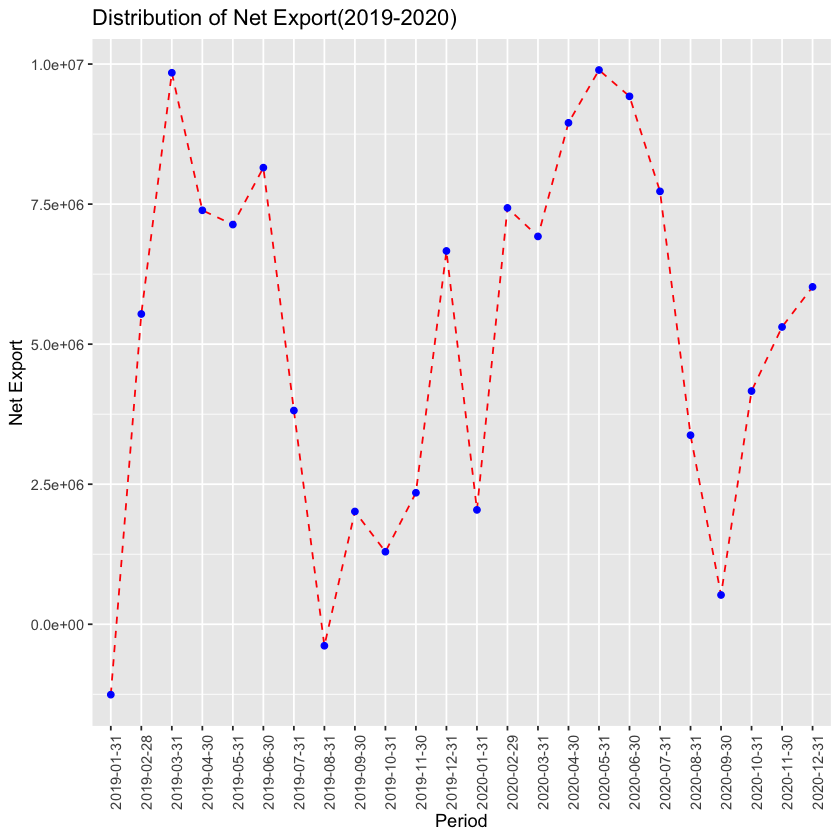

In [17]:
net_export_plot <- net_export %>% ggplot(aes(x=Period, y=net_export, group=1)) +
geom_line(linetype = "dashed", color="red") +
geom_point(color="blue") +
theme(axis.text.x = element_text(angle = 90)) +
labs(title = "Distribution of Net Export(2019-2020)", x= "Period", y= "Net Export")
net_export_plot

With net export, those that decreases indicate that export is less than import.

There are decreases between March 2019 to April 2019, June 2019 to August 2019 and September 2019 to November 2019 but I won't interpret them as there is no Covid during those times.

There is a decrease between December 2019 to January 2020 (6663986-2041613) by 4,622,373 net export and this is when Covid was announced. 
Businesses were probably scared to export as the effects of Covid to the economy is still unknown hence we can see a significant decrease.

There is another decrease between February 2020 to March 2020 (7431809-6923146) by 508,664 net export and this is when the nation was preparing to be in lockdown. 
Business that exports were not allowed to export unless essential.

Another significant decrease is between July 2020 to September 2020 (7727574-522589) by 7,204,985 net export. This could be because that the border was closed so exports were limited.

https://www.rnz.co.nz/news/national/437359/timeline-the-year-of-covid-19-in-new-zealand

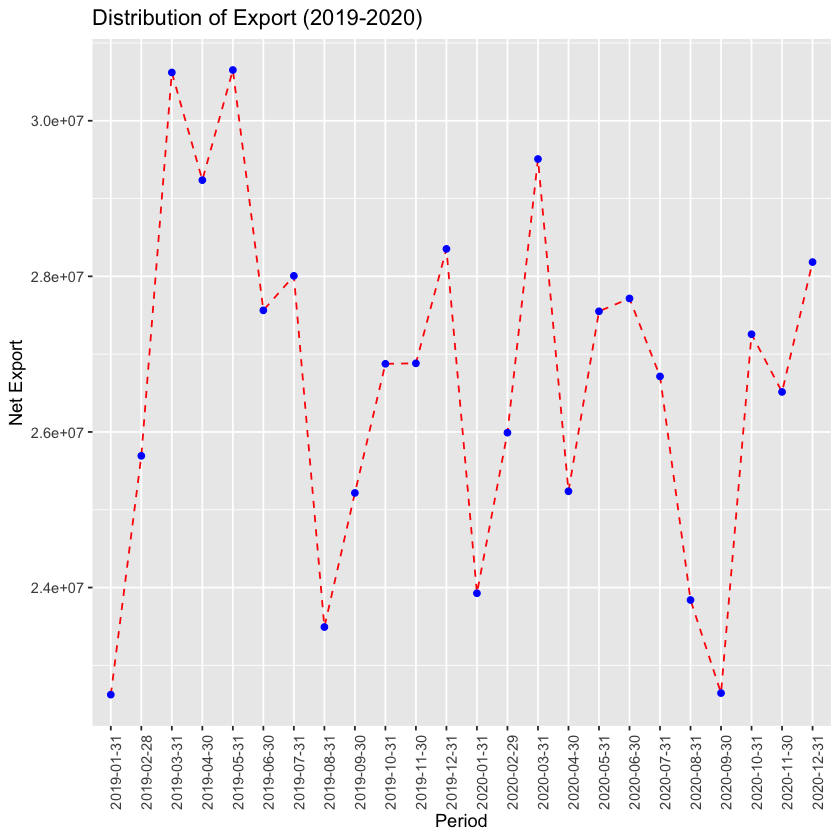

In [18]:
export_plot <- net_export %>% ggplot(aes(x=Period, y=export, group=1)) +
geom_line(linetype = "dashed", color="red") +
geom_point(color="blue") +
theme(axis.text.x = element_text(angle = 90)) +
labs(title = "Distribution of Export (2019-2020)", x= "Period", y= "Net Export")
export_plot

Another representation is this plot that only shows the distribution of export.

The decreases for this plot are the same as the decreases for net export.
    
This supports the idea that the number of export during that time period were lower.

Overall, this implies that net export was affected during Covid.

----

### Getting the 'Total Number of Tourist' dataset

The previous datasets are obtained using API. 

The datasets below are obtained using web-scraping.

In [19]:
link = "https://en.wikipedia.org/wiki/Tourism_in_New_Zealand"
weblink = read_html(link)
weblink %>% typeof()
weblink %>% glimpse()

[1] "list"

List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"


Parses the link via read_html(link).

typeof() tells us it is of type list.

glimpse() tells us it is an "xml_document" so we can use the package 'xml2'.

Our target is to get the table from weblink so we tried doing it this way. 

weblink %>% html_element(".wikitable sortable jquery-tablesorter") %>% html_table()

However this produces an error. Did a little bit of investigating and realised that the table that I need is in a list of lists.

Here is what it shows.

In [20]:
tourism <- weblink %>% html_nodes("table")
tourism

{xml_nodeset (11)}
 [1] <table class="wikitable sortable" style="font-size:90%; text-align:right ...
 [2] <table role="presentation" class="mbox-small plainlinks sistersitebox" s ...
 [3] <table class="nowraplinks hlist mw-collapsible autocollapse navbox-inner ...
 [4] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
 [5] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
 [6] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
 [7] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
 [8] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
 [9] <table class="nowraplinks navbox-subgroup" style="border-spacing:0"><tbo ...
[10] <table class="nowraplinks mw-collapsible autocollapse navbox-inner" styl ...
[11] <table class="nowraplinks mw-collapsible autocollapse navbox-inner" styl ...

The first table is what I need so I'll be indexing to retrieve it. 

In [21]:
tourism %<>% .[[1]] %>% html_table()
tourism

Country,2016,2017,2018,2019,2020,Change (%)2018–19
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Australia,"1,409,200","1,472,160","1,494,541","1,537,988","359,781",2.9
United States of America,"291,392","330,128","352,074","367,958","124,818",4.5
United Kingdom,"220,976","249,264","237,166","231,712","94,255",2.3
"China, People's Republic of","409,008","417,872","448,189","407,141","58,508",9.2
Germany,"96,848","104,864","102,087","98,050","36,671",4.0
Canada,"59,760","67,280","71,261","73,037","30,791",2.5
"Korea, Republic of","82,384","91,168","87,853","88,481","26,326",0.7
Japan,"100,736","102,048","99,784","97,682","25,784",2.1
India,"52,016","61,440","67,953","66,775","18,179",1.7


By indexing then passing in html_table(), the desired table is retrieved. 

In [22]:
tourism %<>% na.omit() %>% gather(key = year,
                                 value = visitors, c("2016", "2017", "2018", "2019", "2020"))
tourism

Country,Change (%)2018–19,year,visitors
<chr>,<dbl>,<chr>,<chr>
Australia,2.9,2016,"1,409,200"
United States of America,4.5,2016,"291,392"
United Kingdom,2.3,2016,"220,976"
"China, People's Republic of",9.2,2016,"409,008"
Germany,4.0,2016,"96,848"
Canada,2.5,2016,"59,760"
"Korea, Republic of",0.7,2016,"82,384"
Japan,2.1,2016,"100,736"
India,1.7,2016,"52,016"


The dataframe has the years spread out making it difficult to wrangle so I converted it into a long data format first.

Passed in na.omit() to get rid of the nulls.

Then, passed in gather(key = year, value = visitors, c("2016", "2017", "2018", "2019", "2020")) to create a new column called 'year' and 'visitors'.

'Visitors' will then take the values from the year so we have the columns 'year' and 'visitors' which make it easier to wrangle.

In [23]:
tourism %<>% group_by(year) %>% filter(Country == "Total")
tourism %<>% rename(Year = year)
tourism

Country,Change (%)2018–19,Year,visitors
<chr>,<dbl>,<chr>,<chr>
Total,0.7,2016,"3,499,939"
Total,0.7,2017,"3,733,707"
Total,0.7,2018,"3,863,217"
Total,0.7,2019,"3,888,473"
Total,0.7,2020,"996,350"


I want to get the total visitors per year.

Therefore, start with group_by(year) to group in distinct 'year' then filter(Country == "Total") as the total visitor for that 'year' is already in the dataframe.

Renamed 'year' into 'Year' to be consistent.

In [24]:
tourism$num_visitors <- as.numeric(c(3499939, 3733707, 3863217, 3888473, 996350))
tourism$Year = as.numeric(tourism$Year)
tourism %<>% select(c(Year, num_visitors))
tourism

Year,num_visitors
<dbl>,<dbl>
2016,3499939
2017,3733707
2018,3863217
2019,3888473
2020,996350


We want both the columns Year and num_visitors to be the same class for consistency reasons.
    
Hnece, I did that via tourism$Year = as.numeric(tourism$Year).

Then we pass in select(c(Year, num_visitors)) to only include the target columns in the dataframe.

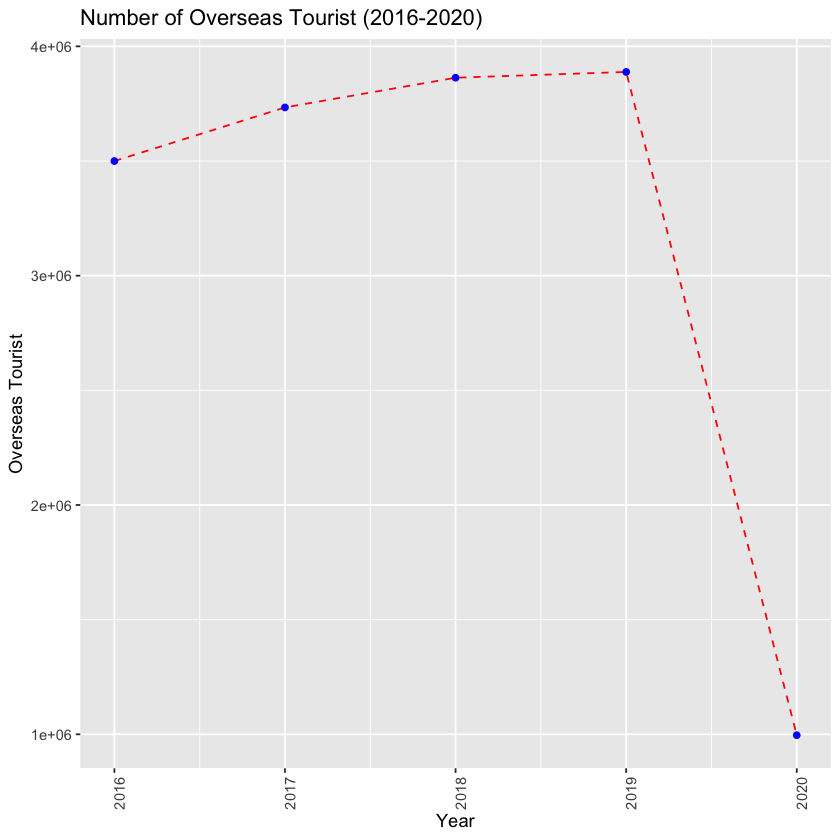

In [25]:
tourism_plot <- tourism %>% ggplot(aes(x=Year, y=num_visitors, group=1)) +
geom_line(linetype = "dashed", color="red") +
geom_point(color="blue") +
theme(axis.text.x = element_text(angle = 90)) +
labs(title = "Number of Overseas Tourist (2016-2020)", x= "Year", y= "Overseas Tourist")
tourism_plot

The plot shows that there is a decrease in the number of tourist arrivals from 2019 to 2020 by (3888473 - 996350) = 2,892,123 million. 

This is due to borders being closed.


Overall, this implies that number of tourists were affected during Covid.

---

### Getting the 'GDP' dataset

In [26]:
wiki_link = "https://en.wikipedia.org/wiki/Economy_of_New_Zealand"
wiki_page = read_html(wiki_link)
wiki_page %>% typeof()
wiki_page %>% glimpse()

[1] "list"

List of 2
 $ node:<externalptr> 
 $ doc :<externalptr> 
 - attr(*, "class")= chr [1:2] "xml_document" "xml_node"


Parses the link and passed in typeof() to know that the link is of type list.

Then glimpse() to know that it is an xml_document so we can webscrape it.

In [27]:
gdp = wiki_page %>% html_element(".wikitable") %>% html_table()
gdp

Year,Gross domestic product (NZ$ millions),1 US dollar exchange,Inflation index(2000=100),Per capita income
<chr>,<chr>,<chr>,<int>,<dbl>
1980[26],"93,517",NZD 1.02,30,58.67
1981,"96,287",,NA,NA
1982,"99,058",,NA,NA
1983,"98,935",,NA,NA
1984,"105,719",,NA,NA
1985[26],"107,001",NZD 2.00,53,38.93
1986,"108,939",,NA,NA
1987,"111,592",,NA,NA
1988,"112,212",,NA,NA


Scraping this is pretty starightforward contrary to the previous one.

Passing in the css selector via html_element(".wikitable") to point to that specific table then html_table() to read and return that table.

In [28]:
gdp %<>% rename(GDP = 'Gross domestic product  (NZ$ millions)')
gdp

Year,GDP,1 US dollar exchange,Inflation index(2000=100),Per capita income
<chr>,<chr>,<chr>,<int>,<dbl>
1980[26],"93,517",NZD 1.02,30,58.67
1981,"96,287",,NA,NA
1982,"99,058",,NA,NA
1983,"98,935",,NA,NA
1984,"105,719",,NA,NA
1985[26],"107,001",NZD 2.00,53,38.93
1986,"108,939",,NA,NA
1987,"111,592",,NA,NA
1988,"112,212",,NA,NA


Renamed the column 'Gross domestic product  (NZ$ millions)' into 'GDP' for consistency reasons. 

In [29]:
gdp %<>% select(Year, GDP) %>% 
filter(Year %in% c("2016", "2017", "2018", "2019", "2020"))
gdp$Year = as.numeric(gdp$Year)
gdp

Year,GDP
<dbl>,<chr>
2016,"234,669"
2017,"242,919"
2018,"251,224"
2019,"257,329"
2020,"249,633"


The dataframe has many null values in the columns we do not want. 

Remove them via select(Year, GDP) which only selects 'Year' and 'GDP'.

Then filter(Year %in% c("2016", "2017", "2018", "2019", "2020")) which returns the rows with the years between '2016' to '2020'.

Then gdp$Year = as.numeric(gdp$Year) to turn all years into numeric for consistency reasons.

I chose the years 2016 to 2020 to show the trend upto 2019 followed by a trend going down to 2020. In addition, the graph would make it easy to determine the change between 2019 - 2020.

We didn't start at, let's say 2000, as that is not the focused of our graph. 

In addition, starting at 2000 would compress the graph making it diffidult to see what happened between 2019 and 2020.

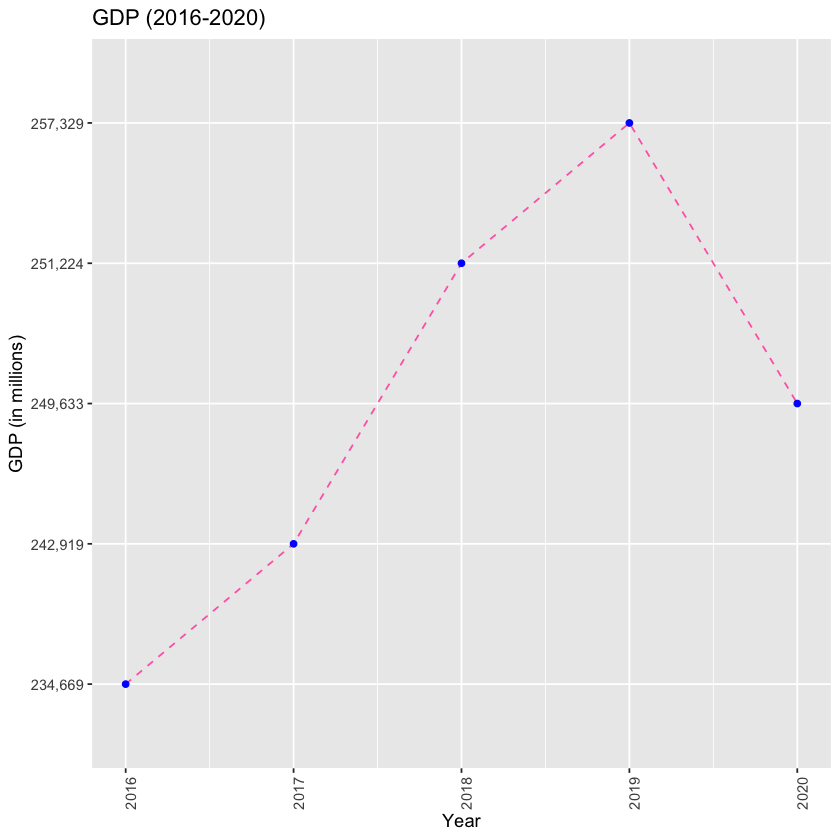

In [30]:
gdp_plot <- gdp %>% ggplot(aes(x=Year, y=GDP, group=1)) + 
geom_line(linetype = "dashed", color="hotpink") + 
geom_point(color="blue") + 
theme(axis.text.x = element_text(angle = 90)) + 
labs(title = "GDP (2016-2020)", x = "Year", y = "GDP (in millions)")
gdp_plot

GDP continues to increase up to 2019. 

Then it decreases between 2019 and 2020 by (257,329,000,000 - 249,633,000,000) = 7,696,000,000 billion NZ $. A significant loss.

Overall, this implies that NZ's GDP was affected during Covid.

---

### GDP relational table

This section here links all the dataframes we have so far into one dataframe to make some plots.

In [31]:
a1 <- filled_jobs
a2 <- net_export

In [32]:
a1 %<>% mutate(Date = ymd(Period), Year = year(Date)) %>% filter(Year == 2019 | Year == 2020) %>% group_by(Year) %>% 
summarise(mean_annual_filled_jobs = mean(total_filled_jobs))
a1

Year,mean_annual_filled_jobs
<dbl>,<dbl>
2019,2163856
2020,2189677


This was done so that we have an annual number of filled jobs for the years 2019 and 2020.

Also for consistency reasons as all the other datasets have the years 2019 and 2020.

We did this by extracting the year from 'Period' and creating a new column called 'Year' via mutate(Date = ymd(Period), Year = year(Date)).

Then, select only those with the rows 2019 and 2020 via filter(Year == 2019 | Year == 2020) as that is our target.

Then, passing in group_by(Year) %>% summarise(filled_jobs_annually = mean(total_filled_jobs)) groups by the year 2019 and 2020 separately 
and computes the mean of filled jobs for each year.

In [33]:
a2 %<>% mutate(Date = ymd(Period), Year = year(Date)) %>% filter(Year == 2019 | Year == 2020) %>% group_by(Year) %>% 
summarise(mean_annual_net_export = mean(net_export))
a2

Year,mean_annual_net_export
<dbl>,<dbl>
2019,4379381
2020,5981966


Same logic applies here like the one above. 

The only difference is that the dataset from net_export. 

In [34]:
joined_plot <- left_join(a1, a2, by="Year") %>% left_join(tourism, by="Year") %>% left_join(gdp, by="Year")
joined_plot

Year,mean_annual_filled_jobs,mean_annual_net_export,num_visitors,GDP
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2019,2163856,4379381,3888473,"257,329"
2020,2189677,5981966,996350,"249,633"


At this point, all datasets have the same column name and class.

This is the reason why we changed all the columns 'Year' to have the same exact name and same class so they can be joined.


The code above joins all the datasets into one by column/key 'Year' via left_join().

Then we can make some graphs out of it.

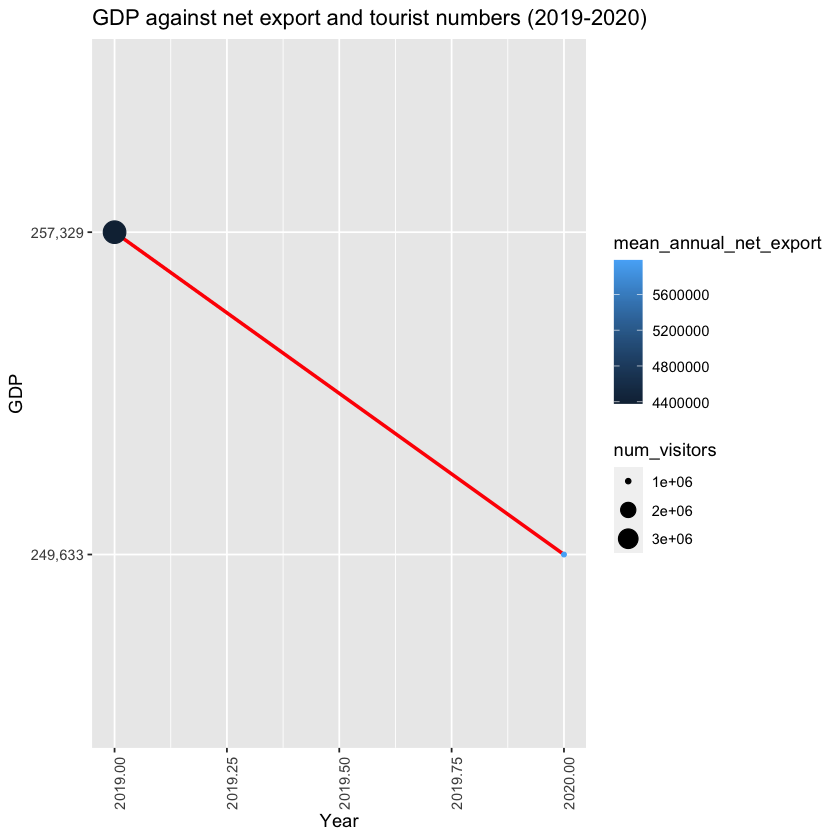

In [35]:
relational_plot1 <- joined_plot %>% ggplot(aes(x=Year, y=GDP, size=num_visitors, colour=mean_annual_net_export, group=1)) + 
geom_line(colour="red", lwd=1) +
geom_point() +
labs(title = "GDP against net export and tourist numbers (2019-2020)", x="Year", y="GDP", size="num_visitors", colour="mean_annual_net_export" ) + 
theme(axis.text.x = element_text(angle = 90))
relational_plot1

The plot shows that the GDP decreases from 2019 - 2020.

The net export in 2020 is greater than of 2019 whereas the number of tourists in 2020 is less than that of 2019. 

However, because the GDP decreases, this indicates that the number of tourists have a significant impact in GDP than net export.

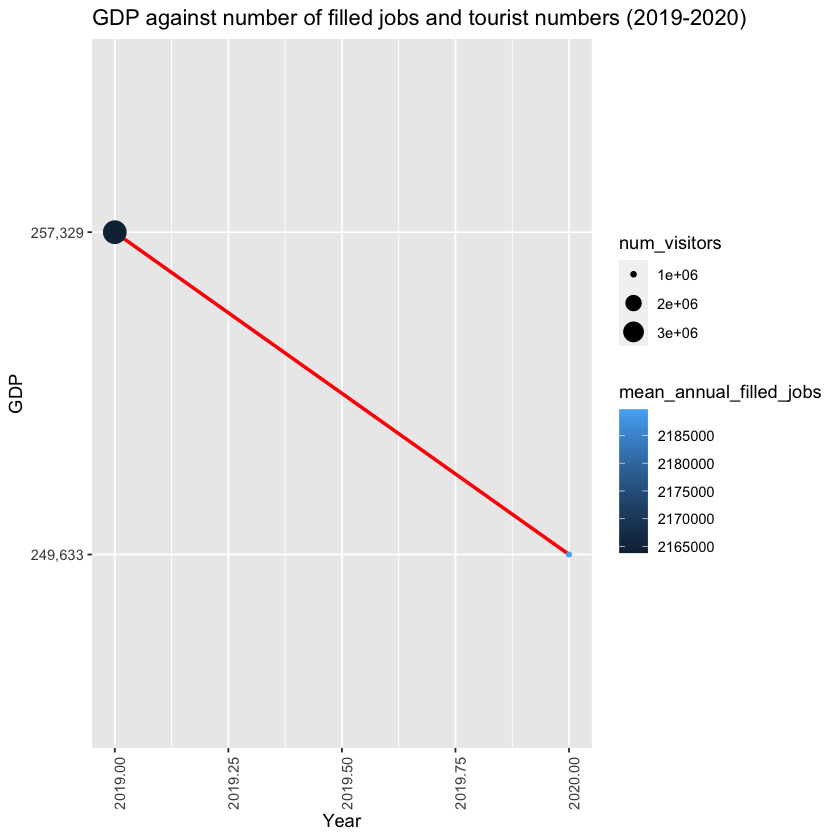

In [36]:
relational_plot2 <- joined_plot %>% ggplot(aes(x=Year, y=GDP, size=num_visitors, colour = mean_annual_filled_jobs, group=1)) + 
geom_line(color="red", lwd=1) +
geom_point() +
labs(title = "GDP against number of filled jobs and tourist numbers (2019-2020)", x="Year", y="GDP", size="num_visitors" , colour="mean_annual_filled_jobs") + 
theme(axis.text.x = element_text(angle = 90))
relational_plot2

The number of filled jobs in 2020 is greater than of 2019 whereas the number of tourists in 2020 is less than that of 2019.

However, because the GDP decreases, this indicates that the number of tourists have a significant impact in GDP than number of filled jobs.

Overall, tourism plays a massive role in calculating NZ GDP. 

This also makes sense as New Zealand has always been a huge tourist destination.

Tourism's contribution to the nation's GDP is 5.5% (directly) and another 3.8% (indirectly) making a total of 9.3%. The sudden disappearance of tourist would reflect on the nation's GDP. A negative correlation. 

A decrease in the number of tourist indicates a decrease in GDP according to this investigation.

To answer our main question, number of tourists is a factor that affected the economy during Covid.  

https://www.tia.org.nz/about-the-industry/quick-facts-and-figures/

---

### Who would find this project useful?

Business owners would find this project useful.

This project tells them to always have a plan B as things are shaky during the times of Covid. 

They should expect their business to not always be filled especially during lockdown, or business owners specialising in export should expect less exports.

They can create a plan to handle this situation by preparing early before lockdown start. 

I would also recommend this project to those who want to put up a tourism business. 

This project would tell them otherwise due to decreasing number of tourists.